# My project sets out to find out what kinds of behaviors/ad activity tend to lead to a purchase

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime

### I did most of my data cleaning in SQL since that's where my data lives

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355846 entries, 0 to 355845
Data columns (total 16 columns):
CONVERSION               355846 non-null int64
SITES                    355846 non-null int64
FIRST_TOUCH              355846 non-null object
IMPRESSIONS              355846 non-null int64
CLICKS                   355846 non-null int64
EXPOSED                  355846 non-null int64
BRAND                    355846 non-null object
PRICE_POINT              355846 non-null object
TYPE                     355846 non-null object
QVVRATIO                 355846 non-null int64
VISITS                   280311 non-null float64
QVS                      355846 non-null int64
PAGES                    276412 non-null float64
PAGESPER                 276412 non-null float64
FIRST_TOUCH_DAYOFWEEK    355846 non-null int64
FIRST_TOUCH_MONTH        355846 non-null int64
dtypes: float64(3), int64(9), object(4)
memory usage: 43.4+ MB


In [4]:
df.head()

CONVERSION  SITES FIRST_TOUCH  IMPRESSIONS  CLICKS  EXPOSED BRAND  \
0           1      4      2/6/18          282       0        1    MM   
1           1      3    12/25/16          184       1        1    MM   
2           1      2    11/14/17          179       1        1    MM   
3           1      6     10/4/16         1240       5        1    MM   
4           1      1      2/8/18          147       0        1    MM   

  PRICE_POINT TYPE  QVVRATIO  VISITS  QVS  PAGES  PAGESPER  \
0        high  not         1     2.0    2    9.0       5.0   
1        high  not         8     8.0    8  210.0     210.0   
2        high  not         1     1.0    1    5.0       5.0   
3        high  not         1    14.0   13   79.0       6.0   
4        high  not         1     1.0    1   46.0      46.0   

   FIRST_TOUCH_DAYOFWEEK  FIRST_TOUCH_MONTH  
0                      2                  2  
1                      0                 12  
2                      2                 11  
3                      2                 10  
4                      4                  2

In [5]:
df['FIRST_TOUCH'] = pd.to_datetime(df.FIRST_TOUCH)
#Turning this into a date instead of an object

In [6]:
df.head()

CONVERSION  SITES FIRST_TOUCH  IMPRESSIONS  CLICKS  EXPOSED BRAND  \
0           1      4  2018-02-06          282       0        1    MM   
1           1      3  2016-12-25          184       1        1    MM   
2           1      2  2017-11-14          179       1        1    MM   
3           1      6  2016-10-04         1240       5        1    MM   
4           1      1  2018-02-08          147       0        1    MM   

  PRICE_POINT TYPE  QVVRATIO  VISITS  QVS  PAGES  PAGESPER  \
0        high  not         1     2.0    2    9.0       5.0   
1        high  not         8     8.0    8  210.0     210.0   
2        high  not         1     1.0    1    5.0       5.0   
3        high  not         1    14.0   13   79.0       6.0   
4        high  not         1     1.0    1   46.0      46.0   

   FIRST_TOUCH_DAYOFWEEK  FIRST_TOUCH_MONTH  
0                      2                  2  
1                      0                 12  
2                      2                 11  
3                      2                 10  
4                      4                  2

### The data isn't super complete but if you convert you have to have visited once so I'll fillna that way

In [7]:
df.VISITS = df[df['QVS'] > 0].VISITS.fillna(df['QVS'])
#the visits were a little wonky so I have to fill some nulls
#if they have a QV, which is a visit that had activity, they definitely visited so that's my first proxy
#if they converted they had to have visited the site
#otherwise I'll just say they didn't visit

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355846 entries, 0 to 355845
Data columns (total 16 columns):
CONVERSION               355846 non-null int64
SITES                    355846 non-null int64
FIRST_TOUCH              355846 non-null datetime64[ns]
IMPRESSIONS              355846 non-null int64
CLICKS                   355846 non-null int64
EXPOSED                  355846 non-null int64
BRAND                    355846 non-null object
PRICE_POINT              355846 non-null object
TYPE                     355846 non-null object
QVVRATIO                 355846 non-null int64
VISITS                   96724 non-null float64
QVS                      355846 non-null int64
PAGES                    276412 non-null float64
PAGESPER                 276412 non-null float64
FIRST_TOUCH_DAYOFWEEK    355846 non-null int64
FIRST_TOUCH_MONTH        355846 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(9), object(3)
memory usage: 43.4+ MB


In [9]:
df.VISITS = df[df['CONVERSION'] == 1].VISITS.fillna(1)

In [10]:
df[df['VISITS'].isnull()].QVS.sort_values(ascending = False)
#why are there still null visits for QVS > 0 when I already fillna'd???

250595    42
232521    40
252396    37
291350    33
297592    26
237277    17
145010    17
113173    15
146055    11
241786    10
225900    10
325360     8
141525     7
318782     6
225893     6
149851     6
232519     6
189066     6
258626     6
287003     5
349955     5
323929     5
225343     5
145009     5
271335     4
328654     4
291309     4
241784     4
169327     4
144627     4
          ..
272342     0
272370     0
272357     0
272369     0
272368     0
272367     0
272366     0
272365     0
272364     0
272363     0
272362     0
272361     0
272360     0
272359     0
272358     0
272356     0
272343     0
272355     0
272354     0
272353     0
272352     0
272351     0
272350     0
272349     0
272348     0
272347     0
272346     0
272345     0
272344     0
105846     0
Name: QVS, Length: 250000, dtype: int64

In [11]:
df.VISITS = df[df['QVS'] > 0].VISITS.fillna(df['QVS'])

In [12]:
df[df['VISITS'].isnull()].QVS.sort_values(ascending = False)
#now they seem to be gone

355845    0
182377    0
182390    0
182389    0
182388    0
182387    0
182386    0
182385    0
182384    0
182383    0
182382    0
182381    0
182380    0
182379    0
182378    0
182376    0
182392    0
182375    0
182374    0
182373    0
182372    0
182371    0
182370    0
182369    0
182368    0
182367    0
182366    0
182365    0
182364    0
182363    0
         ..
269107    0
269108    0
269135    0
269134    0
269133    0
269132    0
269131    0
269130    0
269129    0
269128    0
269127    0
269126    0
269125    0
269124    0
269123    0
269122    0
269121    0
269120    0
269119    0
269118    0
269117    0
269116    0
269115    0
269114    0
269113    0
269112    0
269111    0
269110    0
269109    0
11        0
Name: QVS, Length: 259122, dtype: int64

In [13]:
df.VISITS = df.VISITS.fillna(0)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355846 entries, 0 to 355845
Data columns (total 16 columns):
CONVERSION               355846 non-null int64
SITES                    355846 non-null int64
FIRST_TOUCH              355846 non-null datetime64[ns]
IMPRESSIONS              355846 non-null int64
CLICKS                   355846 non-null int64
EXPOSED                  355846 non-null int64
BRAND                    355846 non-null object
PRICE_POINT              355846 non-null object
TYPE                     355846 non-null object
QVVRATIO                 355846 non-null int64
VISITS                   355846 non-null float64
QVS                      355846 non-null int64
PAGES                    276412 non-null float64
PAGESPER                 276412 non-null float64
FIRST_TOUCH_DAYOFWEEK    355846 non-null int64
FIRST_TOUCH_MONTH        355846 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(9), object(3)
memory usage: 43.4+ MB


### We didn't have data for pages for some rows so I want to fill it in with the mean based on visits

In [15]:
df.groupby("VISITS").mean()

CONVERSION      SITES  IMPRESSIONS      CLICKS   EXPOSED  QVVRATIO  \
VISITS                                                                       
0.0       0.039194   1.318225    11.348261    0.054395  0.999923  0.000000   
1.0       0.975168   1.930241    53.184170    1.243553  0.999206  0.447955   
2.0       0.995568   2.376894    93.559562    1.535366  0.998203  0.623405   
3.0       0.997845   2.636853   126.215625    1.701509  0.998707  0.760345   
4.0       0.998552   2.875282   157.569842    1.799646  0.999034  0.853556   
5.0       0.998888   2.909071   176.945976    1.863273  0.999111  0.950200   
6.0       0.998172   3.041438   191.861974    1.908897  0.998781  1.010969   
7.0       0.999610   3.144084   203.060914    2.010152  0.999610  1.019133   
8.0       0.999499   3.245491   224.114729    2.115731  0.998497  1.117234   
9.0       1.000000   3.269803   240.854080    2.109589  0.998809  1.129244   
10.0      0.998579   3.347548   258.707889    2.303483  0.999289  1.167733   
11.0      0.999157   3.320405   281.041315    2.111298  1.000000  1.104553   
12.0      1.000000   3.421264   279.845537    2.260782  0.998997  1.183551   
13.0      1.000000   3.522727   312.868421    2.259569  1.000000  1.278708   
14.0      1.000000   3.461538   289.275304    2.421053  0.998650  1.253711   
15.0      0.998445   3.653188   332.772939    2.800933  1.000000  1.401244   
16.0      1.000000   3.604736   334.071038    2.797814  0.998179  1.213115   
17.0      0.996124   3.651163   341.612403    2.476744  1.000000  1.269380   
18.0      1.000000   3.760504   359.502101    2.701681  1.000000  1.430672   
19.0      1.000000   3.821759   385.854167    2.638889  1.000000  1.527778   
20.0      1.000000   3.908854   414.250000    2.411458  1.000000  1.533854   
21.0      1.000000   3.737705   375.885246    2.666667  1.000000  1.139344   
22.0      1.000000   3.733333   378.447619    2.888889  1.000000  1.333333   
23.0      1.000000   3.665541   351.922297    3.452703  1.000000  1.554054   
24.0      1.000000   3.645669   453.665354    3.216535  1.000000  1.291339   
25.0      1.000000   4.016194   454.906883    2.979757  1.000000  1.319838   
26.0      0.995671   3.675325   392.606061    3.826840  1.000000  1.696970   
27.0      1.000000   4.059701   439.791045    2.990050  1.000000  1.199005   
28.0      1.000000   4.155440   461.025907    3.968912  1.000000  1.704663   
29.0      1.000000   3.768293   403.371951    3.067073  1.000000  1.341463   
...            ...        ...          ...         ...       ...       ...   
452.0     1.000000   2.000000   253.000000    0.000000  1.000000  1.000000   
456.0     1.000000   6.000000   342.000000   15.000000  1.000000  1.000000   
458.0     1.000000   4.000000  3942.000000    0.000000  1.000000  1.000000   
466.0     1.000000   5.000000   196.000000    2.000000  1.000000  2.000000   
478.0     1.000000   7.000000   223.000000   16.000000  1.000000  1.000000   
488.0     1.000000   4.500000   204.500000    5.000000  1.000000  1.500000   
502.0     1.000000   5.000000   471.000000    2.000000  1.000000  1.000000   
522.0     1.000000   4.000000   369.000000   10.000000  1.000000  1.000000   
532.0     1.000000   6.000000   156.000000   40.000000  1.000000  1.000000   
568.0     1.000000   6.000000   329.000000   11.000000  1.000000  1.000000   
583.0     1.000000   5.000000   426.000000    9.000000  1.000000  1.000000   
591.0     1.000000   4.000000  1486.000000    2.000000  1.000000  1.000000   
610.0     1.000000   5.000000   317.000000   64.000000  1.000000  1.000000   
613.0     1.000000   7.000000   710.000000    0.000000  1.000000  1.000000   
652.0     1.000000   6.000000   960.000000    6.000000  1.000000  2.000000   
685.0     1.000000   9.000000  6223.000000    7.000000  1.000000  1.000000   
698.0     1.000000   6.000000   981.500000   11.500000  1.000000  1.000000   
724.0     1.000000   8.000000   936.000000    1.000000  1.000000  1.000000   
751.0     1.000000   4.000000 

In [16]:
df[df.VISITS >0].PAGESPER.mean()

8.297782514667688

### Since Pages and Pagesper are columns that have null values, it seems like ~8 is the average pagesper

In [17]:
df.PAGESPER = df[df['VISITS'] > 0].PAGESPER.fillna(8)

In [18]:
df.PAGESPER = df.PAGESPER.fillna(0)

In [19]:
df.PAGES = df.PAGESPER * df.VISITS

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355846 entries, 0 to 355845
Data columns (total 16 columns):
CONVERSION               355846 non-null int64
SITES                    355846 non-null int64
FIRST_TOUCH              355846 non-null datetime64[ns]
IMPRESSIONS              355846 non-null int64
CLICKS                   355846 non-null int64
EXPOSED                  355846 non-null int64
BRAND                    355846 non-null object
PRICE_POINT              355846 non-null object
TYPE                     355846 non-null object
QVVRATIO                 355846 non-null int64
VISITS                   355846 non-null float64
QVS                      355846 non-null int64
PAGES                    355846 non-null float64
PAGESPER                 355846 non-null float64
FIRST_TOUCH_DAYOFWEEK    355846 non-null int64
FIRST_TOUCH_MONTH        355846 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(9), object(3)
memory usage: 43.4+ MB


In [21]:
df.QVVRATIO = df.QVS/df.VISITS

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355846 entries, 0 to 355845
Data columns (total 16 columns):
CONVERSION               355846 non-null int64
SITES                    355846 non-null int64
FIRST_TOUCH              355846 non-null datetime64[ns]
IMPRESSIONS              355846 non-null int64
CLICKS                   355846 non-null int64
EXPOSED                  355846 non-null int64
BRAND                    355846 non-null object
PRICE_POINT              355846 non-null object
TYPE                     355846 non-null object
QVVRATIO                 96724 non-null float64
VISITS                   355846 non-null float64
QVS                      355846 non-null int64
PAGES                    355846 non-null float64
PAGESPER                 355846 non-null float64
FIRST_TOUCH_DAYOFWEEK    355846 non-null int64
FIRST_TOUCH_MONTH        355846 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(8), object(3)
memory usage: 43.4+ MB


In [23]:
df.QVVRATIO = df.QVVRATIO.fillna(0)

### We're ready to start exploring!

In [24]:
#I want to look at conversion rate by datetime features
count_by_weekday = df['CONVERSION'].groupby(df['FIRST_TOUCH_DAYOFWEEK']).value_counts()

In [25]:
count_by_weekday

FIRST_TOUCH_DAYOFWEEK  CONVERSION
0                      0             32826
                       1             14739
1                      0             38328
                       1             15641
2                      0             38508
                       1             16539
3                      0             37642
                       1             14967
4                      0             37154
                       1             15415
5                      0             34338
                       1             14364
6                      0             31204
                       1             14181
Name: CONVERSION, dtype: int64

In [26]:
dfcount = count_by_weekday.to_frame()

In [27]:
dfcount.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 14 entries, (0, 0) to (6, 1)
Data columns (total 1 columns):
CONVERSION    14 non-null int64
dtypes: int64(1)
memory usage: 661.0 bytes


In [28]:
dfcount

CONVERSION
FIRST_TOUCH_DAYOFWEEK CONVERSION            
0                     0                32826
                      1                14739
1                     0                38328
                      1                15641
2                     0                38508
                      1                16539
3                     0                37642
                      1                14967
4                     0                37154
                      1                15415
5                     0                34338
                      1                14364
6                     0                31204
                      1                14181

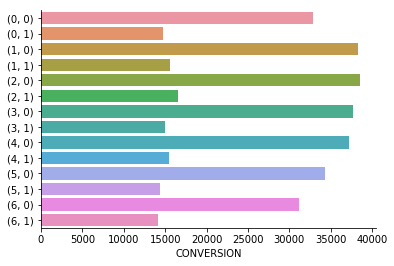

In [29]:
sns.barplot(dfcount.CONVERSION,dfcount.index)
sns.despine()
#volume per weekday doesn't really change

In [30]:
rate_by_weekday = df['CONVERSION'].groupby(df['FIRST_TOUCH_DAYOFWEEK']).agg(['sum','count'])

In [31]:
rate_by_weekday

sum  count
FIRST_TOUCH_DAYOFWEEK              
0                      14739  47565
1                      15641  53969
2                      16539  55047
3                      14967  52609
4                      15415  52569
5                      14364  48702
6                      14181  45385

In [32]:
rate_by_weekday.columns = ['conversions','total']

In [33]:
rate_by_weekday

conversions  total
FIRST_TOUCH_DAYOFWEEK                    
0                            14739  47565
1                            15641  53969
2                            16539  55047
3                            14967  52609
4                            15415  52569
5                            14364  48702
6                            14181  45385

In [34]:
rate_by_weekday['conversionrate'] = rate_by_weekday['conversions']/rate_by_weekday['total']

In [35]:
rate_by_weekday

conversions  total  conversionrate
FIRST_TOUCH_DAYOFWEEK                                    
0                            14739  47565        0.309871
1                            15641  53969        0.289815
2                            16539  55047        0.300452
3                            14967  52609        0.284495
4                            15415  52569        0.293234
5                            14364  48702        0.294937
6                            14181  45385        0.312460

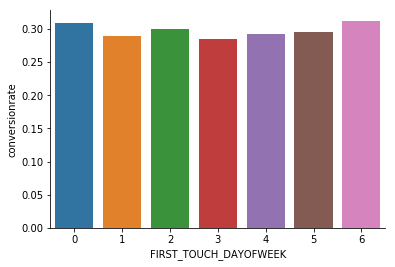

In [36]:
sns.barplot(rate_by_weekday.index,rate_by_weekday.conversionrate)
sns.despine()
#there's no real difference between what day of the week the first touch was

In [37]:
first_touch_weekend = []
for i in df.FIRST_TOUCH_DAYOFWEEK:
    if i in (0,6):
        first_touch_weekend.append(1)
    else:
        first_touch_weekend.append(0)
df['first_touch_weekend'] = first_touch_weekend

In [38]:
rate_by_weekend = df['CONVERSION'].groupby(df['first_touch_weekend']).agg(['sum','count'])

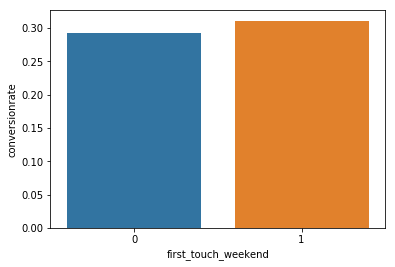

In [39]:
rate_by_weekend.columns = ['conversions','total']
rate_by_weekend['conversionrate'] = rate_by_weekend['conversions']/rate_by_weekend['total']
sns.barplot(rate_by_weekend.index,rate_by_weekend.conversionrate)
#nothing here

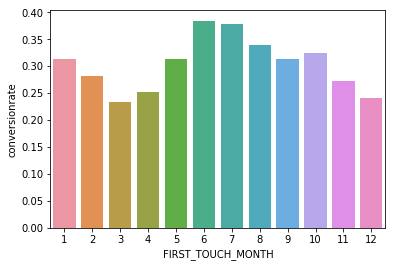

In [40]:
rate_by_month = df['CONVERSION'].groupby(df['FIRST_TOUCH_MONTH']).agg(['sum','count'])
rate_by_month.columns = ['conversions','total']
rate_by_month['conversionrate'] = rate_by_month['conversions']/rate_by_month['total']
sns.barplot(rate_by_month.index,rate_by_month.conversionrate)
#this makes it seem like summer months are higher! Let's make a new column for season

In [41]:
first_touch_season = []
for i in df.FIRST_TOUCH_MONTH:
    if i in (6,7,8):
        first_touch_season.append('summer')
    elif i in (9,10,11):
        first_touch_season.append('fall')
    elif i in (3,4,5):
        first_touch_season.append('spring')
    else:
        first_touch_season.append('winter')
df['first_touch_season'] = first_touch_season

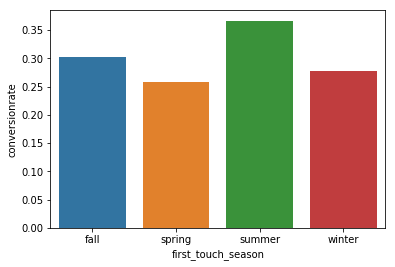

In [42]:
rate_by_season = df['CONVERSION'].groupby(df['first_touch_season']).agg(['sum','count'])
rate_by_season.columns = ['conversions','total']
rate_by_season['conversionrate'] = rate_by_season['conversions']/rate_by_season['total']
sns.barplot(rate_by_season.index,rate_by_season.conversionrate)

In [43]:
df[df['QVVRATIO'] == float("inf")]

Empty DataFrame
Columns: [CONVERSION, SITES, FIRST_TOUCH, IMPRESSIONS, CLICKS, EXPOSED, BRAND, PRICE_POINT, TYPE, QVVRATIO, VISITS, QVS, PAGES, PAGESPER, FIRST_TOUCH_DAYOFWEEK, FIRST_TOUCH_MONTH, first_touch_weekend, first_touch_season]
Index: []

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1078932e8>,
      dtype=object)

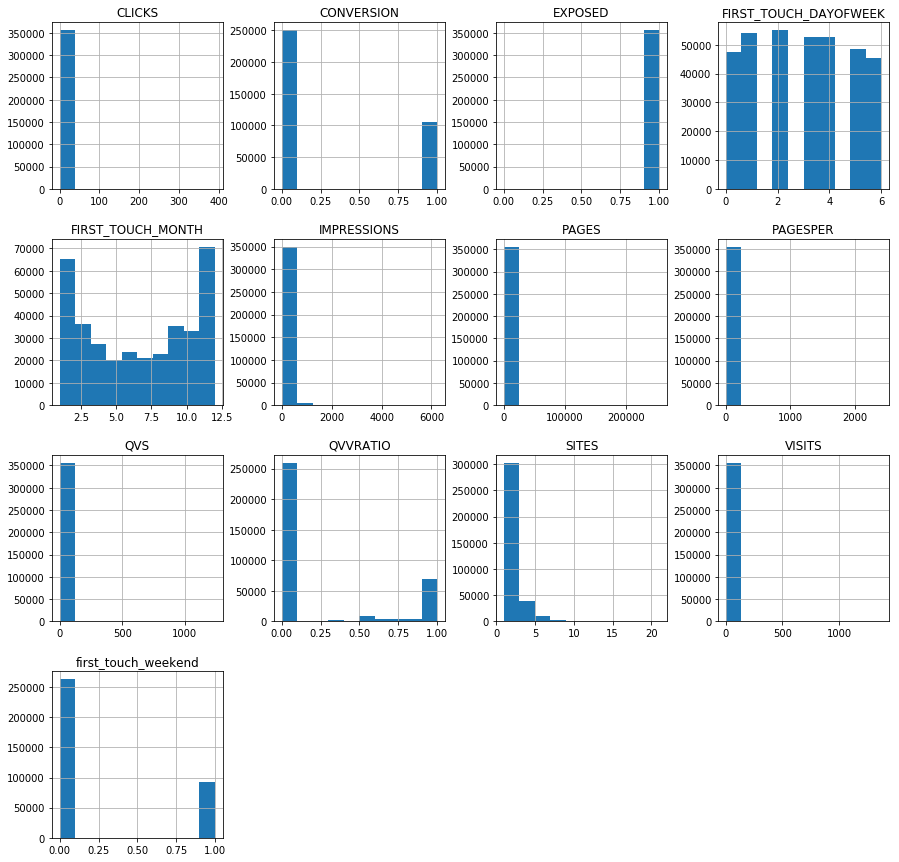

In [44]:
df.hist(figsize=(15,15))
#CLICKS, IMPRESSIONS, PAGES, PAGESPER, QVS, VISITS, SITES are all quite skewed so a scaler is essential in my model

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355846 entries, 0 to 355845
Data columns (total 18 columns):
CONVERSION               355846 non-null int64
SITES                    355846 non-null int64
FIRST_TOUCH              355846 non-null datetime64[ns]
IMPRESSIONS              355846 non-null int64
CLICKS                   355846 non-null int64
EXPOSED                  355846 non-null int64
BRAND                    355846 non-null object
PRICE_POINT              355846 non-null object
TYPE                     355846 non-null object
QVVRATIO                 355846 non-null float64
VISITS                   355846 non-null float64
QVS                      355846 non-null int64
PAGES                    355846 non-null float64
PAGESPER                 355846 non-null float64
FIRST_TOUCH_DAYOFWEEK    355846 non-null int64
FIRST_TOUCH_MONTH        355846 non-null int64
first_touch_weekend      355846 non-null int64
first_touch_season       355846 non-null object
dtypes: datetime64[ns]

In [46]:
df.BRAND.count()

355846

In [47]:
#I realized I forgot to transform this variable into an ordinal value that I think would be more accurate
#The higher the number the more towards repeat orders the products are geared towards
TYPE = []
for i in df.BRAND:
    if i == 'BB':
        TYPE.append(3)
    elif i == 'D8':
        TYPE.append(2)
    else:
        TYPE.append(1)
df['TYPE'] = TYPE

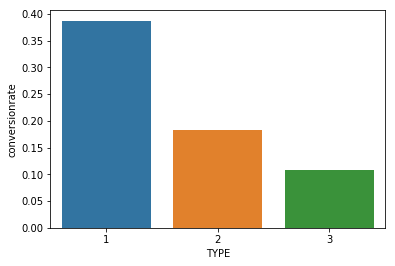

In [48]:
rate_by_type = df['CONVERSION'].groupby(df['TYPE']).agg(['sum','count'])
rate_by_type.columns = ['conversions','total']
rate_by_type['conversionrate'] = rate_by_type['conversions']/rate_by_type['total']
sns.barplot(rate_by_type.index,rate_by_type.conversionrate)
#It seems to me that people are more likely to purchase when repeat orders are not expected
#But let's look at how conversions and total are distributed across types as well

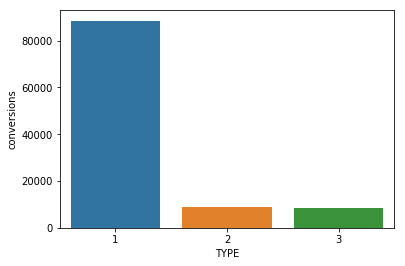

In [49]:
sns.barplot(rate_by_type.index,rate_by_type.conversions)

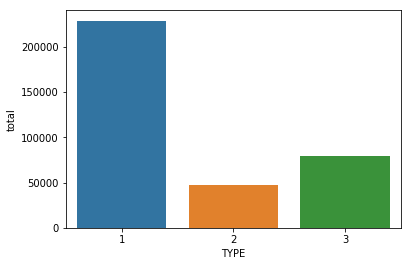

In [50]:
sns.barplot(rate_by_type.index,rate_by_type.total)
#This in conjunction to the bar graph above really makes it seem like less expectation of keeping up a subscription
#makes people more willing to purchase
#Type 2 had about the same # of purchases as type 3 even though there are more total type 3s

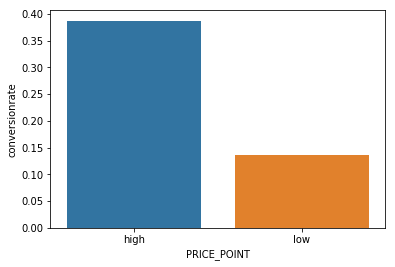

In [51]:
rate_by_price = df['CONVERSION'].groupby(df['PRICE_POINT']).agg(['sum','count'])
rate_by_price.columns = ['conversions','total']
rate_by_price['conversionrate'] = rate_by_price['conversions']/rate_by_price['total']
sns.barplot(rate_by_price.index,rate_by_price.conversionrate)

The fact that the high price point has a higher conversion rate is surprising on its own. However, the business model of the high price point brand is such that when you first make a "purchase" it's like Amazon Wardrobe where you don't pay upfront. Instead, you have the option to return as much of it as you like and only pay for what you end up keeping. In this respect, perhaps the label of PRICE_POINT makes this variable a bit misleading. Instead, it can be interpreted more as a measure of flexibility in terms of how much freedom you have in committing. I'm not going to relabel the variable but it's something to keep in mind when interpreting the models.

In [52]:
#let's get some dummies in for my non-int values
dfwd = pd.get_dummies(df,columns = ['BRAND','PRICE_POINT','first_touch_season'])

In [53]:
dfwd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355846 entries, 0 to 355845
Data columns (total 24 columns):
CONVERSION                   355846 non-null int64
SITES                        355846 non-null int64
FIRST_TOUCH                  355846 non-null datetime64[ns]
IMPRESSIONS                  355846 non-null int64
CLICKS                       355846 non-null int64
EXPOSED                      355846 non-null int64
TYPE                         355846 non-null int64
QVVRATIO                     355846 non-null float64
VISITS                       355846 non-null float64
QVS                          355846 non-null int64
PAGES                        355846 non-null float64
PAGESPER                     355846 non-null float64
FIRST_TOUCH_DAYOFWEEK        355846 non-null int64
FIRST_TOUCH_MONTH            355846 non-null int64
first_touch_weekend          355846 non-null int64
BRAND_BB                     355846 non-null uint8
BRAND_D8                     355846 non-null uint8
BRAND

In [54]:
dfwd = dfwd.drop(labels=['BRAND_MM','PRICE_POINT_high','first_touch_season_spring'],axis=1)
#dropping the superfluous dummies

In [55]:
dfwd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355846 entries, 0 to 355845
Data columns (total 21 columns):
CONVERSION                   355846 non-null int64
SITES                        355846 non-null int64
FIRST_TOUCH                  355846 non-null datetime64[ns]
IMPRESSIONS                  355846 non-null int64
CLICKS                       355846 non-null int64
EXPOSED                      355846 non-null int64
TYPE                         355846 non-null int64
QVVRATIO                     355846 non-null float64
VISITS                       355846 non-null float64
QVS                          355846 non-null int64
PAGES                        355846 non-null float64
PAGESPER                     355846 non-null float64
FIRST_TOUCH_DAYOFWEEK        355846 non-null int64
FIRST_TOUCH_MONTH            355846 non-null int64
first_touch_weekend          355846 non-null int64
BRAND_BB                     355846 non-null uint8
BRAND_D8                     355846 non-null uint8
PRICE

### I think I'm ready to start creating my first model

#### I'll start with a Decision Tree Classifier just because it can help with feature selection as well

In [56]:
X = dfwd.drop(labels=['CONVERSION','FIRST_TOUCH'],axis=1)
y = dfwd.CONVERSION
X_train,X_test,y_train,y_test = train_test_split(X,y)
tree = DecisionTreeClassifier()
params = { 
    'max_depth': [2, 3, 4, 5],
    'min_samples_split' : [5, 10, 15, 20],
    'criterion' : ['gini','entropy']}
grid = GridSearchCV(tree,param_grid=params,cv=5)

In [57]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5], 'min_samples_split': [5, 10, 15, 20], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [58]:
best = grid.best_estimator_

In [60]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355846 entries, 0 to 355845
Data columns (total 19 columns):
SITES                        355846 non-null int64
IMPRESSIONS                  355846 non-null int64
CLICKS                       355846 non-null int64
EXPOSED                      355846 non-null int64
TYPE                         355846 non-null int64
QVVRATIO                     355846 non-null float64
VISITS                       355846 non-null float64
QVS                          355846 non-null int64
PAGES                        355846 non-null float64
PAGESPER                     355846 non-null float64
FIRST_TOUCH_DAYOFWEEK        355846 non-null int64
FIRST_TOUCH_MONTH            355846 non-null int64
first_touch_weekend          355846 non-null int64
BRAND_BB                     355846 non-null uint8
BRAND_D8                     355846 non-null uint8
PRICE_POINT_low              355846 non-null uint8
first_touch_season_fall      355846 non-null uint8
first_touch_se

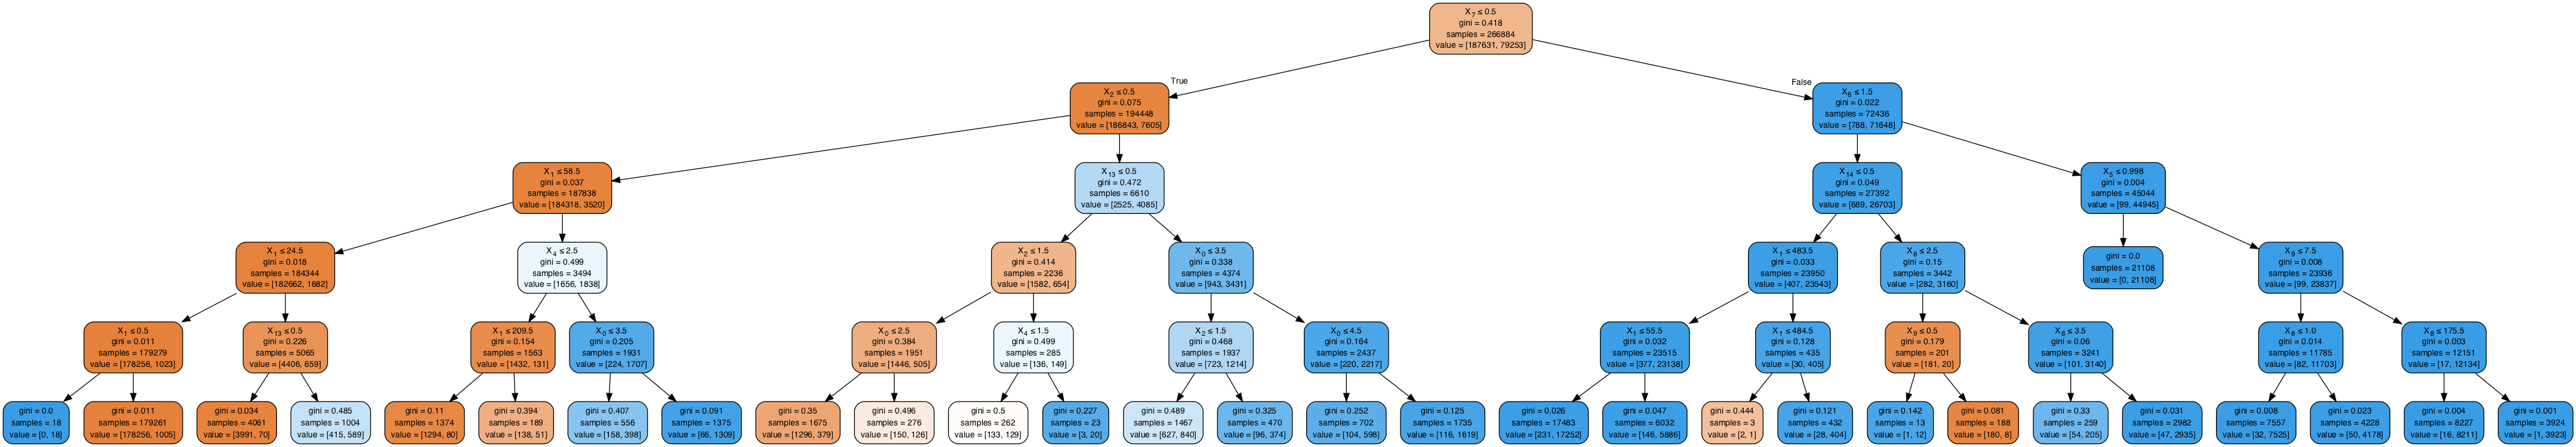

In [61]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(best, out_file=dot_data,  filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
#so this is saying QVS is most important
#then VISITS and CLICKS

Out of all the variables present, the first split is based on either a QV (visit with activity) to the site either happening or not. Since these are all e-commerce sites a purchase couldn't happen without visiting the site so this is a no-brainer. Due to my dataset not being perfect, there are some marked purchasers with 0 visits, probably just from misfires somewhere along the line.

CLICKS being a part of the second split seems a little redundant only because clicks usually lead to visits. After another split on visits on the other side, VISITS comes in. This may be a bit redundant when combined with clicks and QVs but still important.

The top picks for features from the decision tree all make logical sense!

In [62]:
best.score(X_train,y_train)

0.9848623371951859

In [63]:
best.score(X_test,y_test)
#this score is slightly higher than training! No overfitting here

0.9854657044580832

In [64]:
pred = best.predict(X_test)

In [65]:
print(classification_report(y_test,pred))
#I think that recall on 1's is the most important score to maximize because I'd rather include people who don't buy
#than end up excluding people that would buy
#However, all of the scores did nearly the same level of good so not a big concern here.

             precision    recall  f1-score   support

          0       0.99      0.99      0.99     62369
          1       0.97      0.98      0.98     26593

avg / total       0.99      0.99      0.99     88962



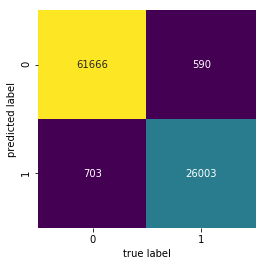

In [66]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap = 'viridis', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

##### Compared to a dummy classifier

In [67]:
from sklearn.dummy import DummyClassifier
dum = DummyClassifier()
dum.fit(X_train,y_train)
print(classification_report(y_test,dum.predict(X_test)))
#Decision tree does much better!!!

             precision    recall  f1-score   support

          0       0.70      0.71      0.70     62369
          1       0.30      0.30      0.30     26593

avg / total       0.58      0.58      0.58     88962



#### Let's try making a logistic regression using all variables with scaled data first since I feel like that's necessary

In [68]:
pipe = make_pipeline(StandardScaler(),LogisticRegression())
params = {'logisticregression__C': [0.1, 1, 5, 10, 100]}
grid = GridSearchCV(pipe,param_grid=params)
grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [0.1, 1, 5, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [69]:
best = grid.best_estimator_
pred = best.predict(X_test)
print(classification_report(y_test,pred))
#this does slightly worse than the decision tree classifier, esp in recall for purchasers

             precision    recall  f1-score   support

          0       0.98      0.99      0.99     62369
          1       0.98      0.96      0.97     26593

avg / total       0.98      0.98      0.98     88962



#### Curious to see how logistic does without scaling the data

In [70]:
pipeo = make_pipeline(LogisticRegression())
params = {'logisticregression__C': [0.1, 1, 5, 10, 100]}
grido = GridSearchCV(pipe,param_grid=params)
grido.fit(X_train,y_train)
besto = grid.best_estimator_
predo = best.predict(X_test)
print(classification_report(y_test,predo))
#so it did exactly the same.... still worse than decision tree

             precision    recall  f1-score   support

          0       0.98      0.99      0.99     62369
          1       0.98      0.96      0.97     26593

avg / total       0.98      0.98      0.98     88962



#### What if I actually select features instead of using everything?

In [71]:
dfwd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355846 entries, 0 to 355845
Data columns (total 21 columns):
CONVERSION                   355846 non-null int64
SITES                        355846 non-null int64
FIRST_TOUCH                  355846 non-null datetime64[ns]
IMPRESSIONS                  355846 non-null int64
CLICKS                       355846 non-null int64
EXPOSED                      355846 non-null int64
TYPE                         355846 non-null int64
QVVRATIO                     355846 non-null float64
VISITS                       355846 non-null float64
QVS                          355846 non-null int64
PAGES                        355846 non-null float64
PAGESPER                     355846 non-null float64
FIRST_TOUCH_DAYOFWEEK        355846 non-null int64
FIRST_TOUCH_MONTH            355846 non-null int64
first_touch_weekend          355846 non-null int64
BRAND_BB                     355846 non-null uint8
BRAND_D8                     355846 non-null uint8
PRICE

In [72]:
Xs = dfwd[['QVVRATIO','EXPOSED','VISITS','first_touch_season_summer']]
ys = dfwd['CONVERSION']
Xs_train,Xs_test,ys_train,ys_test = train_test_split(Xs,ys)
pipe = make_pipeline(StandardScaler(),LogisticRegression())
params = {'logisticregression__C': [0.1, 1, 5, 10, 100]}
grid = GridSearchCV(pipe,param_grid=params)
grid.fit(Xs_train,ys_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [0.1, 1, 5, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [73]:
best = grid.best_estimator_
pred = best.predict(Xs_test)
print(classification_report(ys_test,pred))
#this did worse, especially in recall for purchasers which I care about most

             precision    recall  f1-score   support

          0       0.96      1.00      0.98     62521
          1       0.99      0.90      0.94     26441

avg / total       0.97      0.97      0.97     88962



#### I'm just going to play around with different combos of variables for a bit

In [74]:
Xs = dfwd[['QVVRATIO','EXPOSED','VISITS','first_touch_season_summer','PRICE_POINT_low','QVS']]
ys = dfwd['CONVERSION']
Xs_train,Xs_test,ys_train,ys_test = train_test_split(Xs,ys)
pipe = make_pipeline(StandardScaler(),LogisticRegression())
params = {'logisticregression__C': [0.1, 1, 5, 10, 100]}
grid = GridSearchCV(pipe,param_grid=params)
grid.fit(Xs_train,ys_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [0.1, 1, 5, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [75]:
best = grid.best_estimator_
pred = best.predict(Xs_test)
print(classification_report(ys_test,pred))
#barely improved

             precision    recall  f1-score   support

          0       0.96      1.00      0.98     62551
          1       0.99      0.91      0.94     26411

avg / total       0.97      0.97      0.97     88962



#### Let's try a random forest classifier

In [76]:
forest = RandomForestClassifier()
params = {'criterion': ['gini','entropy'],
          'max_depth': [2, 3, 4, 5,7,10]}
grid = GridSearchCV(forest,param_grid=params)
grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [77]:
best = grid.best_estimator_
pred = best.predict(X_test)
print(classification_report(y_test,pred))
#my decision tree does ever so slightly better in recall for 

             precision    recall  f1-score   support

          0       0.99      0.99      0.99     62369
          1       0.98      0.97      0.98     26593

avg / total       0.99      0.99      0.99     88962



#### From RFC I'd like to look at feature importance

In [82]:
grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [83]:
rfc = RandomForestClassifier(criterion='gini',max_depth=10)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [84]:
rfc.feature_importances_

array([6.88442374e-02, 6.32955180e-02, 5.51784942e-02, 2.50291504e-04,
       7.87408877e-03, 5.10709505e-01, 1.96583010e-01, 4.46937843e-02,
       2.74763557e-02, 1.45425388e-03, 5.91199571e-04, 1.72936511e-03,
       1.84954481e-04, 1.53617096e-03, 6.84092660e-04, 1.65469327e-02,
       8.47259007e-04, 1.26363775e-03, 2.56848474e-04])

In [85]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266884 entries, 81554 to 63160
Data columns (total 19 columns):
SITES                        266884 non-null int64
IMPRESSIONS                  266884 non-null int64
CLICKS                       266884 non-null int64
EXPOSED                      266884 non-null int64
TYPE                         266884 non-null int64
QVVRATIO                     266884 non-null float64
VISITS                       266884 non-null float64
QVS                          266884 non-null int64
PAGES                        266884 non-null float64
PAGESPER                     266884 non-null float64
FIRST_TOUCH_DAYOFWEEK        266884 non-null int64
FIRST_TOUCH_MONTH            266884 non-null int64
first_touch_weekend          266884 non-null int64
BRAND_BB                     266884 non-null uint8
BRAND_D8                     266884 non-null uint8
PRICE_POINT_low              266884 non-null uint8
first_touch_season_fall      266884 non-null uint8
first_touch

Unsurprisingly, this gave basically the same variables as my decision tree to be the most important: QVVRATIO & VISITS. SITES and IMPRESSIONS are more important than I expected, but it's great since those are variables that are in our control (to serve more ads from different partners)

#### Making a logistic regression with the most important 5 features:

In [86]:
Xs = dfwd[['QVVRATIO','VISITS','SITES','IMPRESSIONS','QVS']]
ys = dfwd['CONVERSION']
Xs_train,Xs_test,ys_train,ys_test = train_test_split(Xs,ys)
pipe = make_pipeline(StandardScaler(),LogisticRegression())
params = {'logisticregression__C': [0.1, 1, 5, 10, 100]}
grid = GridSearchCV(pipe,param_grid=params)
grid.fit(Xs_train,ys_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [0.1, 1, 5, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [87]:
best = grid.best_estimator_
pred = best.predict(Xs_test)
print(classification_report(ys_test,pred))
#Still not better than my decision tree!

             precision    recall  f1-score   support

          0       0.98      0.99      0.98     62641
          1       0.98      0.94      0.96     26321

avg / total       0.98      0.98      0.98     88962



#### RFC said depth of 10 is best so I just want to see Decision Tree with that

In [88]:
tree = DecisionTreeClassifier()
params = { 
    'max_depth': [2, 3, 4, 5,10,15],
    'min_samples_split' : [5, 10, 15, 20],
    'criterion' : ['gini','entropy']}
grid = GridSearchCV(tree,param_grid=params,cv=5)
grid.fit(X_train,y_train)
best = grid.best_estimator_

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.673761 to fit



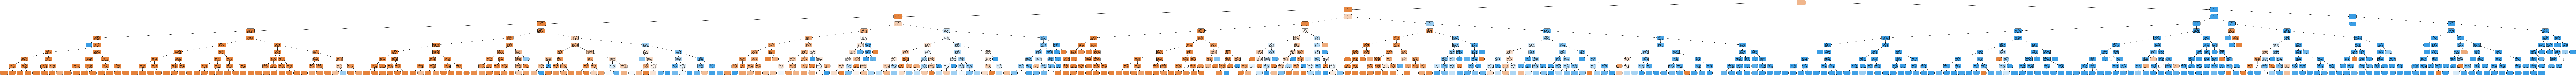

In [89]:
dot_data = StringIO()
export_graphviz(best, out_file=dot_data,  filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [90]:
grid.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [91]:
print(classification_report(y_test,best.predict(X_test)))
#this improved precision on 1's to .98 from .97

             precision    recall  f1-score   support

          0       0.99      0.99      0.99     62369
          1       0.98      0.98      0.98     26593

avg / total       0.99      0.99      0.99     88962



## Conclusion

Surprisingly (to me, at least) the decision tree using all of the variables was actually the best model for this problem, at least using my data set. The fact that it's a decision tree makes it easier to draw actionable conclusions from the analysis though so it's very helpful. For example, if we've tracked a consumer to have a QV but they haven't yet purchased, the fact that VISITS, QVS and IMPRESSIONS are important features tells me that we should specifically target those users with ads.

The reason that I think my models were able to have such high scores/predictive power is because of the nature of my data. In order to cut it down from 1 million+ rows, I instead took all of the purchasers and a random subset of the non-purchasers. I know that's not a particularly good way to split the data, but it does have the added benefit of reducing the effects of any outliers in the data, i.e. people who have visited the site a ton or seen a lot of ads but never purchased, naturally. I also don't have a problem with the exclusion of these outliers because, like I said before, I'd rather include a user in the potential purchaser group who will never purchase than fail to include a potential purchaser from being targeted especially because digital ads are cheap, and that's really the only thing in our control. This way, the model doesn't have to contend with a way to account for the high volume of non-purchasers who likely have the same kinds of activity as the purchasers and potentially become worse at classifying users.

I know that my dataset was a bit unfortunate in its distribution of having so many 0-values throughout but that's just in the nature of the dataset. A load of people are within the demographic or audience that we target but if they never engage with our ads we stop targeting them, but their data is still recorded because they've seen an ad.